In [1]:
!pip -q install pyspark flasgger

In [2]:
import plotly.express as px
from pyspark.sql import SparkSession, functions as f
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.master('local[3]').appName('BankNoteAuthentication').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/18 15:26:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from google.colab import files
files.upload()

Saving BankNote_Authentication.csv to BankNote_Authentication (1).csv


{'BankNote_Authentication.csv': b'variance,skewness,curtosis,entropy,class\r\n3.6216,8.6661,-2.8073,-0.44699,0\r\n4.5459,8.1674,-2.4586,-1.4621,0\r\n3.866,-2.6383,1.9242,0.10645,0\r\n3.4566,9.5228,-4.0112,-3.5944,0\r\n0.32924,-4.4552,4.5718,-0.9888,0\r\n4.3684,9.6718,-3.9606,-3.1625,0\r\n3.5912,3.0129,0.72888,0.56421,0\r\n2.0922,-6.81,8.4636,-0.60216,0\r\n3.2032,5.7588,-0.75345,-0.61251,0\r\n1.5356,9.1772,-2.2718,-0.73535,0\r\n1.2247,8.7779,-2.2135,-0.80647,0\r\n3.9899,-2.7066,2.3946,0.86291,0\r\n1.8993,7.6625,0.15394,-3.1108,0\r\n-1.5768,10.843,2.5462,-2.9362,0\r\n3.404,8.7261,-2.9915,-0.57242,0\r\n4.6765,-3.3895,3.4896,1.4771,0\r\n2.6719,3.0646,0.37158,0.58619,0\r\n0.80355,2.8473,4.3439,0.6017,0\r\n1.4479,-4.8794,8.3428,-2.1086,0\r\n5.2423,11.0272,-4.353,-4.1013,0\r\n5.7867,7.8902,-2.6196,-0.48708,0\r\n0.3292,-4.4552,4.5718,-0.9888,0\r\n3.9362,10.1622,-3.8235,-4.0172,0\r\n0.93584,8.8855,-1.6831,-1.6599,0\r\n4.4338,9.887,-4.6795,-3.7483,0\r\n0.7057,-5.4981,8.3368,-2.8715,0\r\n1.1432,-

In [5]:
df = spark.read.csv('BankNote_Authentication.csv',inferSchema=True, header=True)

In [6]:
df.show(5)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
|  3.4566|  9.5228| -4.0112| -3.5944|    0|
| 0.32924| -4.4552|  4.5718| -0.9888|    0|
+--------+--------+--------+--------+-----+
only showing top 5 rows



In [7]:
df.printSchema()

root
 |-- variance: double (nullable = true)
 |-- skewness: double (nullable = true)
 |-- curtosis: double (nullable = true)
 |-- entropy: double (nullable = true)
 |-- class: integer (nullable = true)



In [8]:
df.select([f.sum(f.isnan(f.col(c)).cast('int')).alias(f'null_{c}') for c in df.columns]).show()

+-------------+-------------+-------------+------------+----------+
|null_variance|null_skewness|null_curtosis|null_entropy|null_class|
+-------------+-------------+-------------+------------+----------+
|            0|            0|            0|           0|         0|
+-------------+-------------+-------------+------------+----------+



In [9]:
print("(",df.count(),",",len(df.columns),")")

( 1372 , 5 )


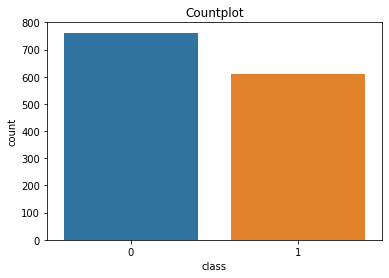

In [10]:
data = df.select('class').toPandas()
sns.countplot(data=data,x='class')
_=plt.title("Countplot")

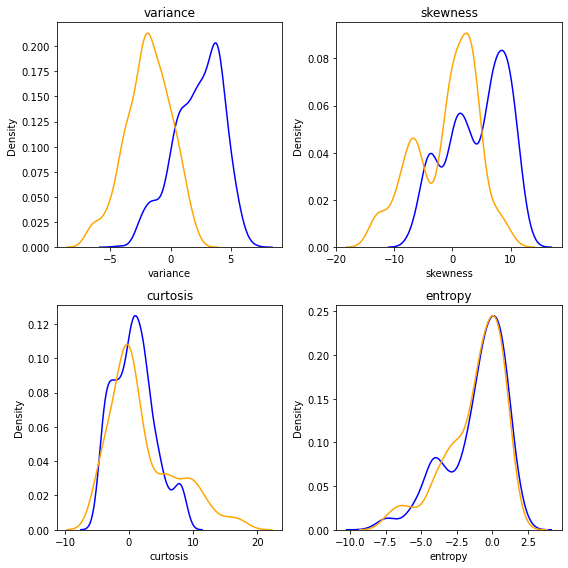

In [11]:
#Seperating the dataset according to class for easy plotting
data_0=df.where(f.col("class")==0)
data_1=df.where(f.col("class")==1)

#KDE plots
cols = df.columns
cols.remove('class')
fig,ax =plt.subplots(2,2,figsize=(8,8))
for feature,axes in zip(cols,ax.ravel()):
    sns.kdeplot(data_0.select(feature).toPandas()[feature],color='blue',ax=axes)
    sns.kdeplot(data_1.select(feature).toPandas()[feature],color='orange',ax=axes)
    axes.set_title(feature)
plt.tight_layout()

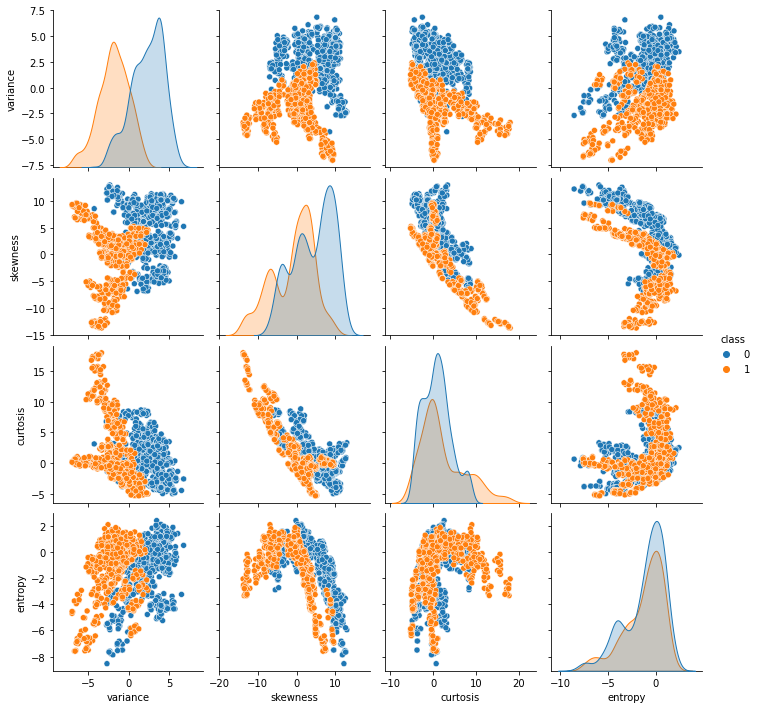

In [12]:
data = df.toPandas()
sns.pairplot(data=data,hue='class')

In [13]:
#displaying the dataframe
df.show(3)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
+--------+--------+--------+--------+-----+
only showing top 3 rows



In [14]:
#Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [15]:
#'cols' is the list of feature names that we have
print(cols)

['variance', 'skewness', 'curtosis', 'entropy']


In [16]:
VecAssembler = VectorAssembler(inputCols=cols,outputCol="features")
#A demo of the output of vector assembler. Later we will assemble all feature transformations in a single pipeline
VecAssembler.transform(df).select("features","class").show(3)

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[3.6216,8.6661,-2...|    0|
|[4.5459,8.1674,-2...|    0|
|[3.866,-2.6383,1....|    0|
+--------------------+-----+
only showing top 3 rows



In [17]:
#let's choose 0.8 as the training split length, because we have only a few rows of data
train,test = df.randomSplit([0.8,0.2])

In [18]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [19]:
#specify input col and output col and fit the scaler
scaler = StandardScaler(inputCol="features",outputCol="features_scaled")

#transform the datasets using a pipeline
feature_pipe = Pipeline(stages=[VecAssembler,scaler]).fit(train)
train = feature_pipe.transform(train)
test = feature_pipe.transform(test)

In [20]:
train.select("features","features_scaled").show(3)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[-7.0364,9.2931,0...|[-2.4699123844847...|
|[-6.9599,8.9931,0...|[-2.4430594060564...|
|[-6.7526,8.8172,-...|[-2.3702930998055...|
+--------------------+--------------------+
only showing top 3 rows



In [21]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

In [22]:
# PCA decmposition to 2 features
pca = PCA(k=3,inputCol="features",outputCol="pca").fit(train)
data = pca.transform(train).select("pca","class")
data.show(3)

21/12/18 15:27:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/12/18 15:27:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+--------------------+-----+
|                 pca|class|
+--------------------+-----+
|[-7.0792120424661...|    1|
|[-6.8235346996065...|    1|
|[-6.7410206329958...|    1|
+--------------------+-----+
only showing top 3 rows



In [23]:
data = data.withColumn("pca",vector_to_array("pca")).select(f.col("class"),f.col("pca")[0],f.col("pca")[1],f.col("pca")[2])
data.show(3)

+-----+-------------------+-------------------+-------------------+
|class|             pca[0]|             pca[1]|             pca[2]|
+-----+-------------------+-------------------+-------------------+
|    1|-7.0792120424661045|-10.166071761807142|-1.3622715332073816|
|    1| -6.823534699606548|-10.055203469131285|-1.2977254965573208|
|    1| -6.741020632995844|  -9.38715975526532|-1.0943003205625739|
+-----+-------------------+-------------------+-------------------+
only showing top 3 rows



In [24]:
data = data.toPandas()

In [25]:
#plotting
fig = px.scatter_3d(data, x='pca[0]', y='pca[1]', z='pca[2]',color='class',title="3D Scatterplot of PCA Features",color_continuous_scale=px.colors.sequential.Viridis)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [26]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [27]:
lr = LogisticRegression(featuresCol="features",labelCol="class",predictionCol='prediction_lr')
params = ParamGridBuilder().addGrid(lr.maxIter,[50,75,100,150,200]).addGrid(lr.regParam,[0,0.0001,0.001,0.01,0.1,0.5]).build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_lr',labelCol='class',metricName='f1')
CValidator = CrossValidator(estimator=lr,estimatorParamMaps=params,evaluator=evaluator,numFolds=5)
CValidator_lr = CValidator.fit(train)

#predictions on test data
predictions_lr= CValidator_lr.transform(test).select('prediction_lr','class')
predictions_lr.show(3)

+-------------+-----+
|prediction_lr|class|
+-------------+-----+
|          1.0|    1|
|          1.0|    1|
|          1.0|    1|
+-------------+-----+
only showing top 3 rows



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Area under the ROC curve: 0.9999
F1 Score: 0.9797
Accuracy: 0.9797


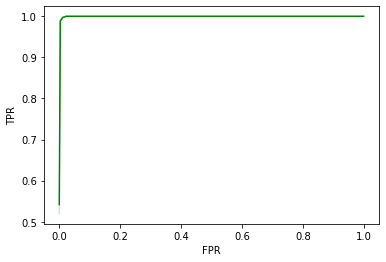

In [28]:
data = CValidator_lr.bestModel.summary.roc.toPandas()
sns.lineplot(data=data,x='FPR',y='TPR',color='green')
print("Area under the ROC curve:",format(CValidator_lr.bestModel.summary.areaUnderROC,'.4f'))
print("F1 Score:",format(evaluator.evaluate(predictions_lr),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy:",format(evaluator.evaluate(predictions_lr),'.4f'))

In [29]:
from pyspark.ml.classification import LinearSVC

In [30]:
svc = LinearSVC(featuresCol='features_scaled',labelCol='class',predictionCol='prediction_svc')
params = ParamGridBuilder().addGrid(svc.maxIter,[50,100,200]).addGrid(svc.regParam,[0,0.001,1]).build()
evaluator.setPredictionCol('prediction_svc')
evaluator.setMetricName('f1')

CValidator_svc = CrossValidator(estimator=svc,estimatorParamMaps=params,evaluator=evaluator).fit(train)

21/12/18 15:31:42 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:32:03 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:33:05 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:33:06 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:33:09 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:33:51 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:34:10 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:34:30 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/18 15:34:31 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


In [31]:
predictions_svc = CValidator_svc.transform(test).select("prediction_svc","class")

In [32]:
print("f1 Score",format(evaluator.evaluate(predictions_svc),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy score: ",format(evaluator.evaluate(predictions_svc),'.4f'))

f1 Score 0.9878
Accuracy score:  0.9878


In [41]:
#Save feature pipe

#feature_pipe.save('feature_pipe')

#Save the model

#CValidator_svc.bestModel.save('bank_note_model_svc')

In [34]:
!pip -q install streamlit

In [35]:
!pip install ipykernel>=5.1.2
!pip install pydeck

In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.pipeline import PipelineModel
import streamlit as st

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.pipeline import PipelineModel

In [38]:
#Load feature_pipe and model

feature_pipe = PipelineModel.load('feature_pipe')
model = LinearSVCModel.load('bank_note_model_svc')
spark = SparkSession.builder.master('local').appName('deployPyspark').getOrCreate()

def predict(variance,skewness,curtosis,entropy,spark):
    schema = "variance FLOAT, skewness FLOAT, curtosis FLOAT, entropy FLOAT"
    data = spark.createDataFrame([[variance,skewness,curtosis,entropy]],schema=schema)
    data = feature_pipe.transform(data)
    prediction = model.transform(data).select("prediction_svc").collect()[0][0]
    return "Fake Note" if(prediction) else "Authentic Note"
    
def noteAuth():
    st.title("Bank Note Authentication")
    st.markdown("Application for predicting the authenticity of Bank Notes")

    variance = float(st.text_input("Variance", 3.6216))
    skewness = float(st.text_input("Skewness",8.6661))
    curtosis = float(st.text_input("Curtosis",-2.8073))
    entropy = float(st.text_input("Entropy",-0.44699))

    if(st.button("Predict")):
        result = predict(variance,skewness,curtosis,entropy,spark)
        st.success(f"Prediction: {result}")

if __name__ == '__main__':
    noteAuth()

2021-12-18 15:35:18.033 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]
